In [1]:
import numpy as np             
import pandas as pd           #Python Data Analysis Library handle data in a user friendly way
#import random
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import scipy as sc



## Rigdge Regression Model with standardized data

### Petrol_Fraction = Petrol/Total_Cars

In [4]:
import seaborn as sns
# sns.pairplot(data)

## Bayesian Linear Regression

In [5]:
# function for Bayesian Linear regression, return posterior mean and 95% CIs
def BLR(X,y,mu_0,Om_0_inv,a_0,b_0,ind_names,N):
    col_names = ['posterior mean','lower 95% bound','upper 95% bound']
    n,p = X.shape
    XtX = X.T.dot(X)
    Om_n_inv = XtX + Om_0_inv
    Om_n = sc.linalg.inv(Om_n_inv)
    term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
    mu_n = Om_n.dot(term1)
    a_n = a_0 + n/2
    term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))+mu_n.dot(Om_n_inv.dot(mu_n))
    b_n = b_0 + term2/2
    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,p))
    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 =sigma2[i]
        cov = s2*Om_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    results = np.column_stack([mu_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=ind_names)
    return results, mu_n, Om_n, a_n, b_n

## Linear Regression

In [6]:
def LRST451(X,y,predictor_names):
    col_names = ['beta','se','lower 95% bound','upper 95% bound']
    XtX = X.T.dot(X)
    XtX_inv = sc.linalg.inv(X.T.dot(X))
    beta = XtX_inv.dot(X.T.dot(y))
    e = y - X.dot(beta)
    n,p = X.shape
    sigma2_hat = e.T.dot(e)/(n-p)
    var_beta = sigma2_hat*(XtX_inv)
    tval = sc.stats.t.ppf(0.975,n-p)
    se_beta = np.sqrt(np.diag(var_beta))
    lower95 = beta - sc.stats.t.ppf(0.975,n-p)*se_beta
    upper95 = beta + sc.stats.t.ppf(0.975,n-p)*se_beta
    results = np.column_stack([beta,se_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=predictor_names)
    return results

## Model Evidence

In [7]:
# Function for Bayes Model Evidence
def ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0): 
    beta = mu_n
    sigma2 = b_n/(a_n-1)
    Om_0 = sc.linalg.inv(Om_0_inv)
    mu = X.dot(beta)
    cov = sigma2*np.eye(X.shape[0])
    ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
    # evaluate log-prior
    lprior = a_0*np.log(b_0)-sc.special.loggamma(a_0)- (a_0+1)*np.log(sigma2)-b_0/sigma2
    lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
    # evaluate log-posterior
    lpost = a_n*np.log(b_n)-sc.special.loggamma(a_n)- (a_n+1)*np.log(sigma2)-b_n/sigma2
    lpost = lpost + sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)
    lmodevid = ll+lprior-lpost
    return lmodevid

## Linear Regression with the best predictors

## Model Evidence for predicting Average_CO2

## OLS with Intercept

In [8]:
# 2.
import statsmodels.api as sm
# predictors = ['All_Electric', 'Total_Vehicles']
# y = standard_data['Average_CO2']
# X = standard_data[predictors]
# X = sm.add_constant(X) 
# model = sm.OLS(y, X).fit()
# model.summary()

# Linear, Ridge and Bayesian Regression with the new data

In [9]:
data = pd.read_csv('veh0203_final_yearly.csv')
data = data.set_index('Year')
data = data.fillna(method = 'ffill')
data.tail(3)

,Petrol,Diesel,All_EV,New_Total,UK_Population,Petrol_Fraction,EV_Fraction,Total_GHGs
Year,,,,,,,,
2017,18348092,12360237,460187,31168516,66238000,0.588674,0.0148,114785.965
2018,18499594,12397636,592197,31489427,66616000,0.587486,0.0188,113280.299
2019,18818368,12286328,758164,31862860,66996000,0.590605,0.0238,113280.299


In [18]:
# Standardize data for simplicity
data_short = data#[data.index>2009]
mat = np.array(data_short.T)
std_mat = np.std(mat, axis = 1)
mean_mat = np.mean(mat, axis = 1)
mat_stand = (mat-mean_mat.reshape(-1,1))/std_mat.reshape(-1,1)
standard_data = pd.DataFrame(mat_stand.T, index = data_short.index, 
                             columns = data.columns)
standard_data.tail(3)
# print(std_mat)
# print(mean_mat)
std_total_vehicle = std_mat[3]
mean_total_vehicle = mean_mat[3]
std_petrol_f = std_mat[5]
mean_petrol_f = mean_mat[5]

std_y = std_mat[-1]
mean_y = mean_mat[-1]

[1.23130005e+06 3.65804849e+06 1.98703960e+05 3.09325400e+06
 2.94086011e+06 1.14468854e-01 6.30397170e-03 3.84177138e+03]
[2.01749183e+07 6.71001831e+06 1.26767538e+05 2.70117042e+07
 6.17795385e+07 7.59485761e-01 4.13846154e-03 1.15193481e+05]


In [11]:
predictors = ['All_EV','Diesel','EV_Fraction','New_Total','Petrol','Petrol_Fraction','UK_Population']

pairs = [[a,b] for a in predictors for b in predictors if a<b]

mask_train = data.index<2017
y = standard_data['Total_GHGs'][mask_train]
a_0 = 0.1
b_0 = 0.1
N = 10000 #Monte Carlo sample size
#nPowers = np.array([2,3,4,5,6])
#K = nPowers.size
K = len(pairs)
Evidence = np.ones(K)

for i in range(K):
    predictors = pairs[i]
    X = standard_data[predictors][mask_train]
    n,p = X.shape
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
    Evidence[i] = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)

-37.3003927123887 ['New_Total', 'Petrol_Fraction']


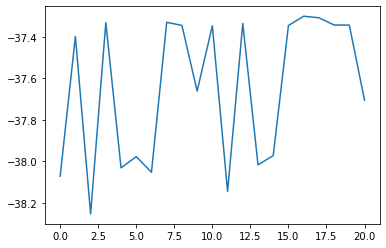

In [12]:
print(np.max(Evidence), pairs[np.argmax(Evidence)])
plt.plot(Evidence)

In [13]:
#Evidence_table = pd.DataFrame([np.array(pairs),Evidence], columns = ['Evidence', 'Predictors'])
model_evidence = pd.DataFrame([[a,b] for a,b in zip(pairs,Evidence)], 
                              columns = ['Predictors','Evidence']).sort_values('Evidence', axis = 0, 
                                                                               ascending = False)
model_evidence.head()

,Predictors,Evidence
16,"[New_Total, Petrol_Fraction]",-37.300393
17,"[New_Total, UK_Population]",-37.307668
7,"[Diesel, New_Total]",-37.329795
3,"[All_EV, Petrol]",-37.331336
12,"[EV_Fraction, Petrol]",-37.334802


In [14]:
import statsmodels.api as sm
predictors = ['New_Total', 'Petrol_Fraction']
y = standard_data['Total_GHGs']
X = standard_data[predictors]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_GHGs   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     28.33
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           6.24e-07
Time:                        15:15:19   Log-Likelihood:                -20.742
No. Observations:                  26   AIC:                             47.48
Df Residuals:                      23   BIC:                             51.26
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.464e-15      0.112  -1.31e-14      1.000      -0.232       0.232
New_Total           2.3292      0.402      5.787      0.000       1.497       3.162
Petrol_Fraction     2.7765      0.402      6.898      0.000       1.944       3.609
==============================================================================
Omnibus:                        0.901   Durbin-Watson:                   0.614
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.769
Skew:                           0.078   Prob(JB):                        0.681
Kurtosis:                       2.172   Cond. No.                         7.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# import statsmodels.api as sm
# predictors = ['UK_Population', 'Petrol_Fraction']
# y = standard_data['Total_GHGs']
# X = standard_data[predictors]
# X = sm.add_constant(X) 
# model = sm.OLS(y, X).fit()
# model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_GHGs   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     4.847
Date:                Sat, 06 Mar 2021   Prob (F-statistic):             0.0175
Time:                        15:15:19   Log-Likelihood:                -32.320
No. Observations:                  26   AIC:                             70.64
Df Residuals:                      23   BIC:                             74.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.464e-15      0.175  -8.37e-15      1.000      -0.362       0.362
UK_Population      -0.8684      2.025     -0.429      0.672      -5.058       3.321
Petrol_Fraction    -0.3258      2.025     -0.161      0.874      -4.516       3.864
==============================================================================
Omnibus:                        1.828   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.077
Skew:                          -0.099   Prob(JB):                        0.584
Kurtosis:                       2.023   Cond. No.                         23.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
y_pred_2019 = (2.3292*1.568302+ 2.7765*(-1.475341))*std_y + mean_y

NameError: name 'std_y' is not defined

one approach with model 3:

the linear regression is 

Y = Total_GHGs

Intercept =-1.464e-15

Total_Vehicles = 2.3292

Petrol_Fraction = 2.7765

some assumption:

1.the linear relationship keep unchangeable during the whole period

2.the number of cars keeps the trend in the future (using arima model)


<ipython-input-22-872c64374fa0>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


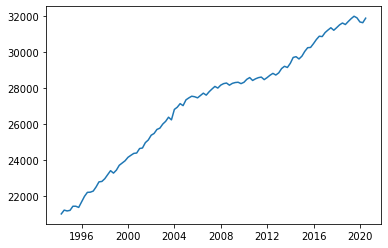

In [22]:
import pandas as pd
import numpy as np
# from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

main = pd.read_csv('./main.csv')


main['time']= pd.to_datetime(main['Quarter'].str.replace(' ','-'))#.replace()pd.to_datetime(df['Quarter'])
main.head()
main = main.set_index('time')
# main[' Cars'] = main[' Cars'].str.replace('..','')
cars = main[' Cars'].dropna(axis=0)

cars = cars[~cars.isin(['..'])]

cars = cars.astype('float')

plt.plot(cars)

# cars_num.columns
# print(time.head())

#upward trend and some fluctuation

# autocorrelation_plot(cars)

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


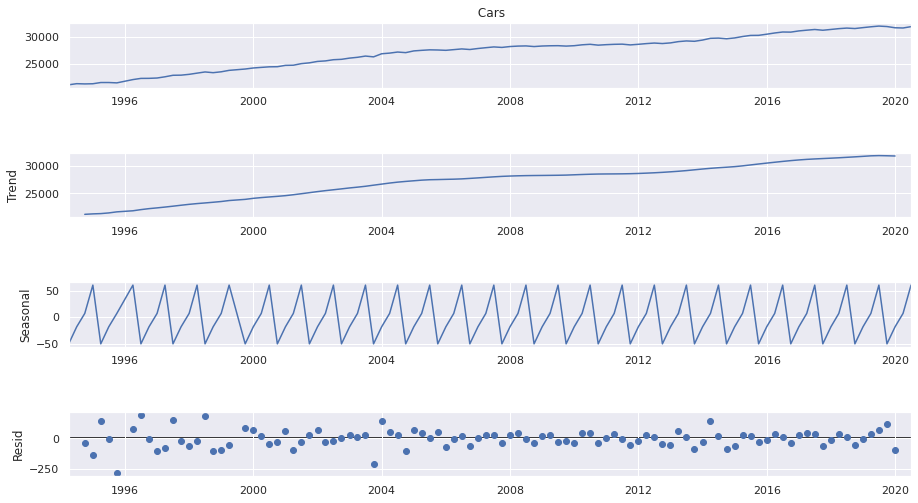

In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(cars.dropna(),freq = 4)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


ADF Statistic: -2.679478
p-value: 0.077657


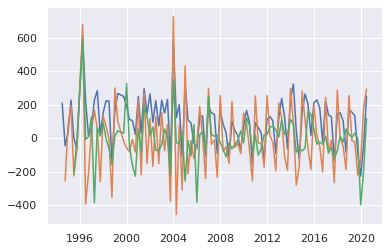

In [24]:
# check the stationarity
from statsmodels.tsa.stattools import adfuller,arma_order_select_ic
from numpy import log
car_diff_4 = cars.diff(4).dropna()
car_diff = cars.diff()[1:]
car_diff_1 = car_diff.diff().dropna()
car_diff_4 = car_diff.diff(4).dropna()
plt.plot(car_diff)
plt.plot(car_diff_1)
plt.plot(car_diff_4)
# print(car_diff)

result = adfuller(car_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.


In [27]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(cars, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#Best model:  ARIMA(3,2,0) #p,d,q
#(1,1,0)
arma_order_select_ic(car_diff, max_ar=3, max_ma=3, ic='aic', trend='c', model_kw=None, fit_kw=None)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1322.785, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1318.807, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1320.643, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1320.558, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1361.303, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.187 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -657.403
Date:                Sat, 06 Mar 2021   AIC                           1318.807
Time:                        15:26:12   BIC                           1324.076
Sample:                             0   HQIC                          1320.941
                                - 104                                       

{'aic':              0            1            2            3
 0  1318.806502  1320.231762  1321.261903  1322.857675
 1  1320.393165  1322.839074  1323.261902  1311.898176
 2  1320.324384  1322.230508          NaN          NaN
 3  1321.523148  1309.786491  1304.770447  1297.397148,
 'aic_min_order': (3, 3)}

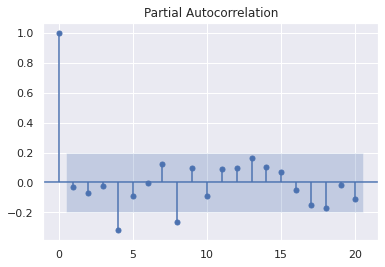

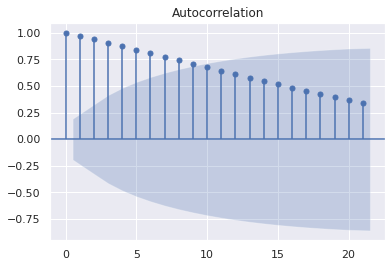

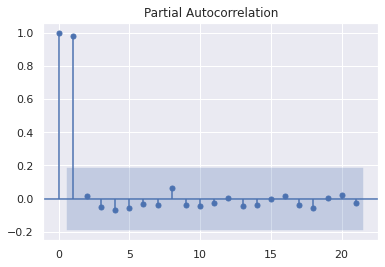

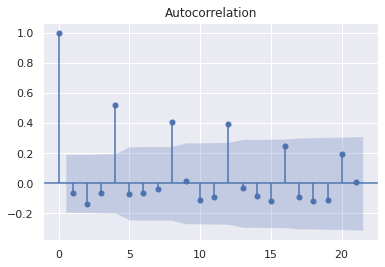

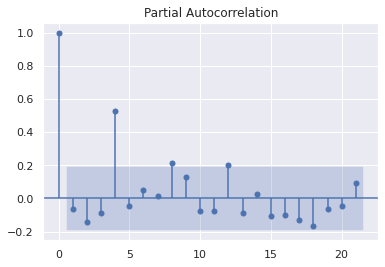

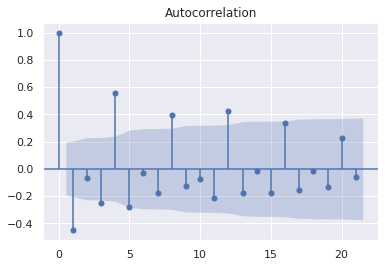

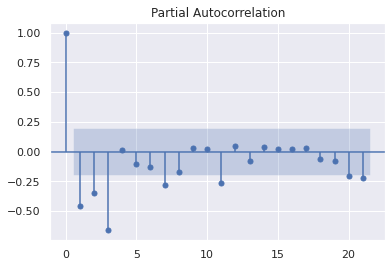

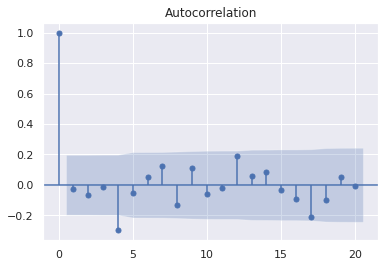

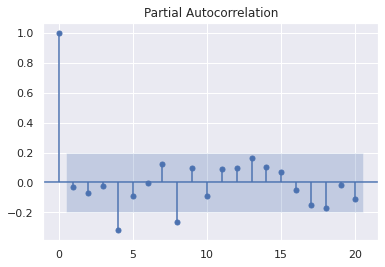

In [28]:
plot_acf(cars)
plot_pacf(cars)
plot_acf(car_diff)
plot_pacf(car_diff)
plot_acf(car_diff_1)
plot_pacf(car_diff_1)
plot_acf(car_diff_4)
plot_pacf(car_diff_4)

                             ARIMA Model Results                              
Dep. Variable:                D. Cars   No. Observations:                  103
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -657.197
Method:                       css-mle   S.D. of innovations            142.821
Date:                Sat, 06 Mar 2021   AIC                           1320.393
Time:                        15:27:15   BIC                           1328.297
Sample:                             1   HQIC                          1323.595
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           105.0522     13.242      7.933      0.000      79.098     131.006
ar.L1.D. Cars    -0.0635      0.099     -0.644      0.520      -0.257       0.130
                                    Root

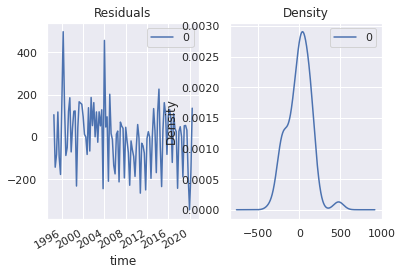

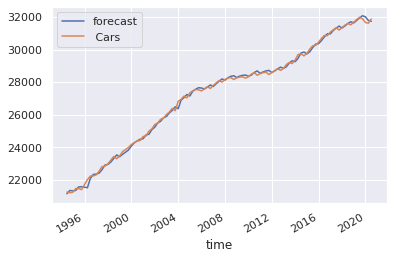

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


                             ARIMA Model Results                              
Dep. Variable:                D. Cars   No. Observations:                   68
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -435.795
Method:                       css-mle   S.D. of innovations            146.889
Date:                Sat, 06 Mar 2021   AIC                            877.591
Time:                        15:27:15   BIC                            884.249
Sample:                             1   HQIC                           880.229
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           109.5808     15.675      6.991      0.000      78.858     140.303
ar.L1.D. Cars    -0.1385      0.122     -1.134      0.257      -0.378       0.101
                                    Root

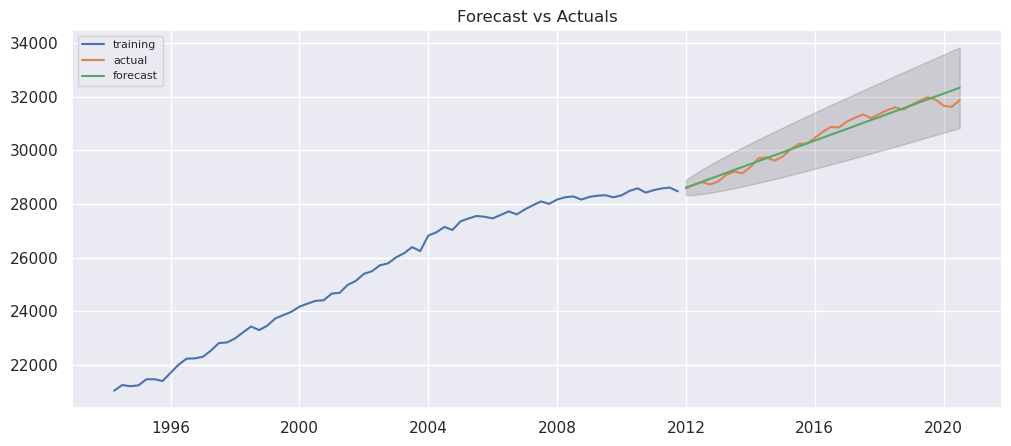

DatetimeIndex(['1994-04-01', '1994-07-01', '1994-10-01', '1995-01-01',
               '1995-04-01', '1995-07-01', '1995-10-01', '1996-04-01',
               '1996-07-01', '1996-10-01',
               ...
               '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01',
               '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-01',
               '2020-04-01', '2020-07-01'],
              dtype='datetime64[ns]', name='time', length=104, freq=None)


In [29]:
#build the arima
from statsmodels.tsa.arima_model import ARIMA

# 3,2,0 ARIMA Model
model = ARIMA(cars, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#predict
fc, se, conf = model_fit.forecast(4*10, alpha=0.05)  # 95% conf 

#if we spilit the data as training and testing data, and calculate the MAE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test = cars[np.round(2/3*len(cars)).astype(int):]
train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mean_absolute_percentage_error(test, fc) #7.295545504861874 acceptable (3,2,0)
#if we use model (3,1,0) 0.5138645256869044
#if we use model (0,1,0) 0.5319200544501159

print(cars.index)

In [30]:
import datetime

def create_assist_date(datestart = None,dateend = None):
	datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
	dateend=datetime.datetime.strptime(dateend,'%Y-%m-%d')
	date_list = []
	date_list.append(datestart.strftime('%Y-%m-%d'))
	while datestart<dateend:
	    datestart+=datetime.timedelta(days = 365/4)
	    date_list.append(datestart.strftime('%Y-%m-%d'))
	return date_list

len(create_assist_date('2020-10-01','2030-10-01'))
new_index = pd.to_datetime(create_assist_date('2020-10-01','2030-09-29')) #2030-12-29 equals to the 2031-01-01
print(new_index)

DatetimeIndex(['2020-10-01', '2020-12-31', '2021-04-01', '2021-07-01',
               '2021-10-01', '2021-12-31', '2022-04-01', '2022-07-01',
               '2022-10-01', '2022-12-31', '2023-04-01', '2023-07-01',
               '2023-10-01', '2023-12-31', '2024-03-31', '2024-06-30',
               '2024-09-30', '2024-12-30', '2025-03-31', '2025-06-30',
               '2025-09-30', '2025-12-30', '2026-03-31', '2026-06-30',
               '2026-09-30', '2026-12-30', '2027-03-31', '2027-06-30',
               '2027-09-30', '2027-12-30', '2028-03-30', '2028-06-29',
               '2028-09-29', '2028-12-29', '2029-03-30', '2029-06-29',
               '2029-09-29', '2029-12-29', '2030-03-30', '2030-06-29',
               '2030-09-29'],
              dtype='datetime64[ns]', freq=None)


                             ARIMA Model Results                              
Dep. Variable:                D. Cars   No. Observations:                  103
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -657.197
Method:                       css-mle   S.D. of innovations            142.821
Date:                Sat, 06 Mar 2021   AIC                           1320.393
Time:                        15:28:13   BIC                           1328.297
Sample:                             1   HQIC                          1323.595
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           105.0522     13.242      7.933      0.000      79.098     131.006
ar.L1.D. Cars    -0.0635      0.099     -0.644      0.520      -0.257       0.130
                                    Root

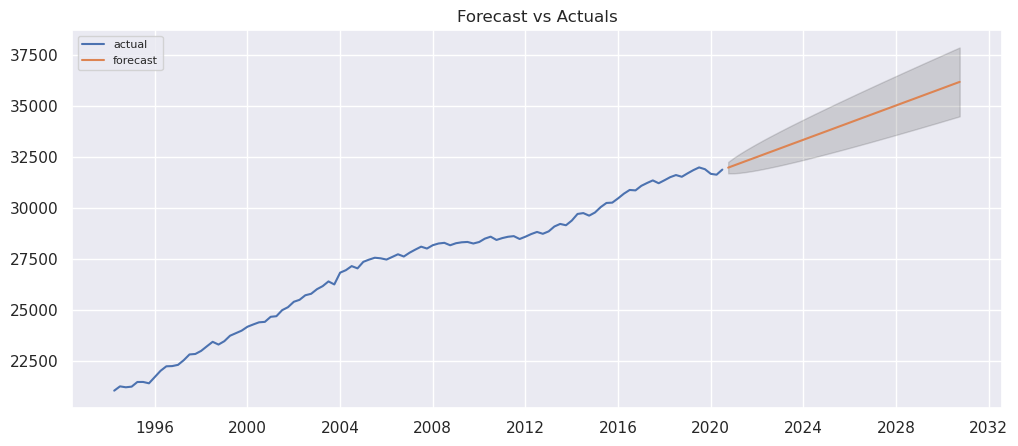

In [31]:
# test = cars[np.round(2/3*len(cars)).astype(int):]
# train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(cars, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# model with whole data and Forecast until 2030
fc, se, conf = model_fit.forecast(4*10+1, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=new_index)
lower_series = pd.Series(conf[:, 0], index=new_index)
upper_series = pd.Series(conf[:, 1], index=new_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#the predicted value of number of cars at the begining of 2030 is 
predict_2030 = fc_series['2029-12-29']

In [32]:
# transform the prediction of number of vehicles from quarterly to yearly

car_num_series = pd.concat([cars.iloc[[-3,-2,-1]],fc_series])
# print(car_num_series)
fc_year = []
for i in range(0, len(car_num_series), 4):
    fc_year.append(car_num_series[i:i+4])
# print(fc_year)  
fc_year_1 =[np.mean(i) for i in fc_year]
# print(len(fc_year_1))
fc_year_1 = pd.DataFrame(fc_year_1)
print(fc_year_1)

               0
0   31778.810042
1   32228.428583
2   32648.629104
3   33068.837827
4   33489.046551
5   33909.255274
6   34329.463997
7   34749.672720
8   35169.881444
9   35590.090167
10  36010.298890


get the prediction for petrol fraction

If we assume that the ratio of Petrol/ (Petrol+diesel) in the following years are the same as the ratio in 2019
then the ratio is 0.713616,--use this one

alternatively if we assume that the ratio of Petrol/ (Petrol+diesel) in the following years are the same as average the ratio from 2001 to 2019 then the ratio is 0.601906836


In [33]:
GB = pd.read_csv('veh0203_final_yearly.csv')
# GB = pd.read_csv('./GB_all_data _Copy.csv')
GB.head()
GB = GB.set_index('Year')
fraction = GB['Petrol_Fraction']
# print(fraction)

ratio = 0.713616
fraction_2030 = (1-0.43)*ratio
fraction_2019 = fraction.loc[2019]

fraction_future = []
for i in range(11):
    fraction = fraction_2019 + (i+1)*(fraction_2030-fraction_2019)/11
    fraction_future.append(fraction)
    
print(len(fraction_future))  
fraction_future = pd.DataFrame(fraction_future)

11


the linear regression is

Y = Total_GHGs

Intercept =-1.464e-15

Total_Vehicles = 2.3292

Petrol_Fraction = 2.7765

In [35]:
Intercept = -1.464e-15
beta_Total_Vehicles =  2.3292
beta_petrol_Fraction = 2.7765
Intercept =pd.DataFrame([Intercept]*11)

std_total_vehicle = std_mat[3]
mean_total_vehicle = mean_mat[3]
std_petrol_f = std_mat[5]
mean_petrol_f = mean_mat[5]

std_y = std_mat[-1]
mean_y = mean_mat[-1]



y = Intercept+ beta_Total_Vehicles*(fc_year_1-mean_total_vehicle)/std_total_vehicle +beta_petrol_Fraction *(fraction_future-mean_petrol_f)/std_petrol_f

y_unstandardize = y*std_y+mean_y
print(y)
print(y_unstandardize)
# print(fraction_future)



            0
0  -24.817377
1  -25.222423
2  -25.627491
3  -26.032559
4  -26.437627
5  -26.842695
6  -27.247763
7  -27.652831
8  -28.057899
9  -28.462968
10 -28.868036
               0
0   19850.791308
1   18294.697546
2   16738.518682
3   15182.339842
4   13626.161002
5   12069.982161
6   10513.803321
7    8957.624481
8    7401.445641
9    5845.266801
10   4289.087961


y_unstandardize is the prediction of Total_GHGs from 2020 to 2030

try arimax

refer to https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

https://www.kaggle.com/poiupoiu/how-to-use-sarimax

In [ ]:
data = pd.DataFrame(data=cars, index=cars.index, columns=['covid'])
data['time']=data.index
# print(data)
date_point = pd.to_datetime('2020Q1')

data.loc[(data['time'] >= date_point), 'covid'] = 1;
data.loc[(data['time'] < date_point), 'covid'] = 0;
# print(data)
covid = data['covid']
# print(covid)

covid_future = np.ones([2,2])
print(covid_future)
print(pd.DataFrame(np.ones([2,2])))

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Variables
endog = cars
exog = sm.add_constant(covid)
endog = np.array(endog, dtype=float)
exog  = np.array(exog , dtype=float)
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(3,2,0))
res = mod.fit(disp=False)
print(res.summary())

print(res.forecast(exog=covid_future ,steps=2))
# fcast_res2 = res.get_forecast(steps=2)

#have not finished